# Automated Fungi Classification (Resnet18)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

#import torch which has many of the functions to build deep learning models and to train them
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#import torchvision, which was lots of functions for loading and working with image data
import torchvision
import torchvision.transforms as transforms

#this is a nice progress bar representation that will be good to measure progress during training
import tqdm

ModuleNotFoundError: No module named 'tqdm'

# Splitting into a training and validation dataset¶

In [2]:
imagenet_means = (0.485, 0.456, 0.406)
imagenet_stds = (0.229, 0.224, 0.225)

transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Resize((224, 224)), 
     transforms.Normalize(imagenet_means, imagenet_stds)])

trainval_dataset = torchvision.datasets.ImageFolder('../Project_1/trainval', transform = transform)

##  Using stratify to split into train and val

In [3]:
train_portion = 0.7
val_portion = 0.3

all_idxes = np.arange(len(trainval_dataset))
class_labels = trainval_dataset.targets

train_idx, val_idx = train_test_split(all_idxes, train_size=train_portion, stratify = class_labels, random_state = 0)


train_dataset = torch.utils.data.Subset(trainval_dataset, train_idx)
val_dataset = torch.utils.data.Subset(trainval_dataset, val_idx)


print(f'Size of train dataset: {len(train_dataset)}')
print(f'Size of val dataset: {len(val_dataset)}')

batch_size = 10

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers = 2)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size,
                                          shuffle=False, num_workers = 2)

Size of train dataset: 732
Size of val dataset: 315


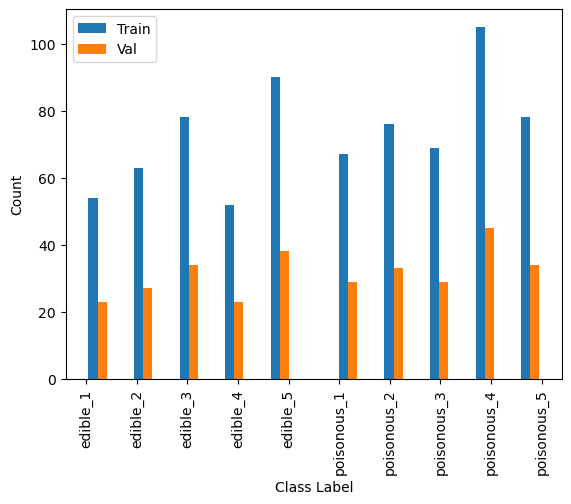

In [4]:
num_classes = len(trainval_dataset.classes)
class_labels = trainval_dataset.classes

train_labels = [data[1] for data in train_dataset]
val_labels = [data[1] for data in val_dataset]

plt.hist([train_labels, val_labels], bins = 20, label = ['Train', 'Val']) 
plt.xlabel('Class Label')
plt.legend()
plt.xticks([i for i in range(num_classes)], class_labels, rotation=90)
plt.ylabel('Count')
plt.show()

In [5]:

lbls, counts = np.unique(train_labels, return_counts = True)

weighting = torch.DoubleTensor([1/x for x in counts])
#sample_weights = weighting[torch.tensor(class_labels)]
sample_weights = weighting[train_labels]

sampler = torch.utils.data.WeightedRandomSampler(sample_weights, len(train_dataset), replacement=True)
#sampler = torch.utils.data.WeightedRandomSampler(sample_weights, len(sample_weights))
balanced_trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          sampler = sampler)



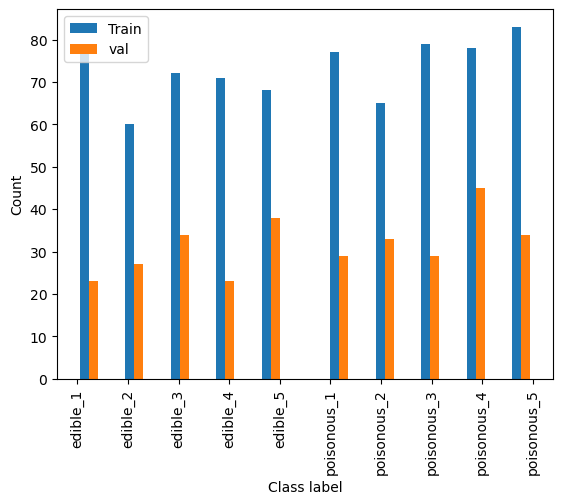

In [6]:

balanced_classes = []
for data in balanced_trainloader:
    ims, tgts = data
    balanced_classes += tgts.tolist()


plt.hist([balanced_classes, val_labels],  bins = 20, label = ['Train', 'val']) 
plt.xticks([i for i in range(num_classes)], class_labels, rotation = 90)
plt.xlabel('Class label')
plt.ylabel('Count')
plt.legend()
plt.show()


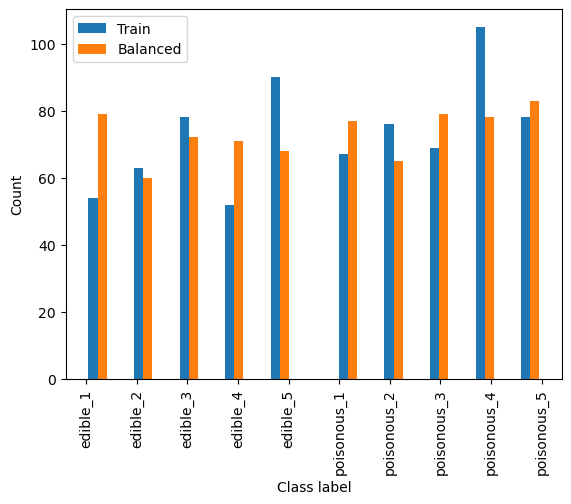

In [7]:

plt.hist([train_labels, balanced_classes],  bins = 20, label = ['Train', 'Balanced']) 
plt.xticks([i for i in range(num_classes)], class_labels, rotation = 90)
plt.xlabel('Class label')
plt.ylabel('Count')
plt.legend()
plt.show()



# Data Augumentation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.41945136..1.82].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.52360594..1.819729].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5472907..1.2977986].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.51187646..1.8186285].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5586449..1.8140491].


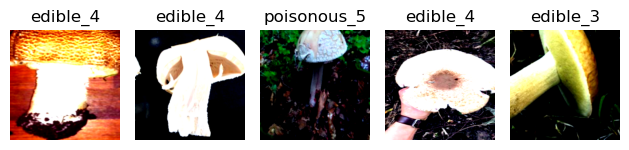

In [8]:
### Add more transforms in here
train_transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
     transforms.RandomResizedCrop((224,224), scale = (0.5, 1))
    ])


#visualise the train dataset with these transforms
data = next(iter(balanced_trainloader))
fig, ax = plt.subplots(1, 5)
for idx in range(5):
    im = data[0][idx]
    lbl = data[1][idx]
    im = train_transform(im)
    train_image = (im.numpy())/2 + 0.5
    label = class_labels[lbl]
    train_image = np.moveaxis(train_image, 0, 2)
    ax[idx].imshow(train_image)
    ax[idx].set_axis_off()
    ax[idx].set_title(label.split('-')[-1])
plt.tight_layout()
plt.show()


# The Model (ResNet18)

In [9]:
def setup_model(num_classes, freeze_backbone = False):
    #### Step 1: Initialise the model with pretrained weights.
    model = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.DEFAULT)

    #### Step 2: Adapt the architecture for the new number of classes.
    in_features = model.fc.in_features
    model.fc = nn.Linear(model.fc.in_features, num_classes)

    #### Step 3: If necessary, freeze any weights.
    if freeze_backbone: 
        for param in model.parameters():
            param.requires_grad = False
        
        # Unfreeze the parameters of the last fully connected layer
        for param in model.fc.parameters():
            param.requires_grad = True

    #### Step 4: Move the model to the GPU if available
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') #this line checks if we have a GPU available
    model = model.to(device)

    return model

resnet_frozen = setup_model(10, True)
print(resnet_frozen)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /tmp/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 476MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Training Time: Transfer Learning with a frozen backbone



Epoch 1 - training phase: 100%|██████████| 74/74 [00:03<00:00, 21.43it/s]


Saving model at epoch 0 with accuracy 0.40634920634920635


Epoch 2 - training phase: 100%|██████████| 74/74 [00:03<00:00, 22.79it/s]


Saving model at epoch 1 with accuracy 0.5587301587301587


Epoch 4 - training phase: 100%|██████████| 74/74 [00:03<00:00, 23.21it/s]


Saving model at epoch 3 with accuracy 0.5873015873015873


Epoch 6 - training phase: 100%|██████████| 74/74 [00:03<00:00, 24.46it/s]


Saving model at epoch 5 with accuracy 0.6412698412698413


Epoch 7 - training phase: 100%|██████████| 74/74 [00:03<00:00, 22.23it/s]


Saving model at epoch 6 with accuracy 0.6476190476190476


Epoch 10 - training phase: 100%|██████████| 74/74 [00:03<00:00, 22.79it/s]


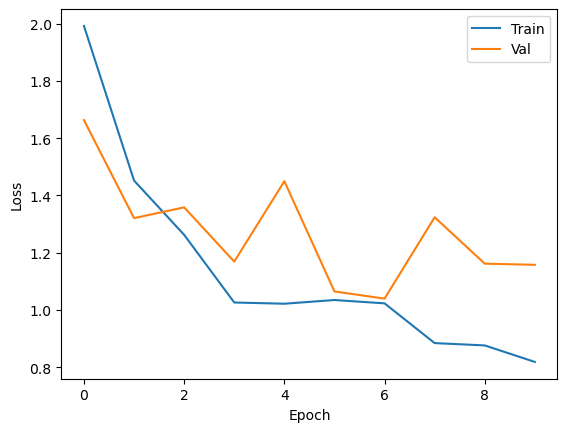

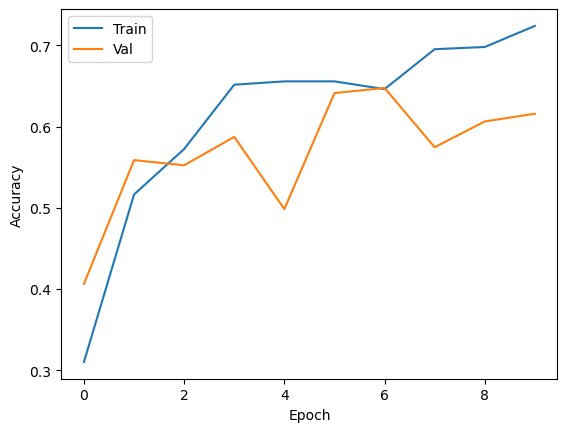

In [10]:
torch.manual_seed(0)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') #this line checks if we have a GPU available

#any hyperparameters
lr = 0.003
total_epochs = 10

#Step 1: Initialise the model.
resnet_frozen = setup_model(10, True)
# Step 2: Define a loss function
criterion = nn.CrossEntropyLoss()
# Step 3: Initialise the SGD optimizer.
optimizer = optim.SGD(resnet_frozen.parameters(), lr=lr, momentum=0.9)


#Step 4: For n epochs (e.g. loss converged/stops changing)
total_train_loss = []
total_train_acc = []
total_val_loss = []
total_val_acc = []
best_acc = 0
for epoch in range(total_epochs):    
    #Step 4A: Put the model in "train" mode
    resnet_frozen.train() 

    #Step 4B: Training loop: For all batches in the training dataset
    train_loss = []
    correct = 0
    total = 0
    for i, data in  tqdm.tqdm(enumerate(balanced_trainloader, 0), total = len(balanced_trainloader), desc = f'Epoch {epoch+1} - training phase'):
        inputs, labels = data

        inputs = train_transform(inputs)
        
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = resnet_frozen(inputs)
        
        loss = criterion(outputs, labels)
        
        loss.backward()
        
        optimizer.step()

        train_loss += [loss.cpu().item()]
        
        predicted = torch.argmax(outputs, axis = 1)
        
        correct += torch.sum(predicted == labels).cpu().item()
        total += len(labels)

    mean_train_loss = np.mean(train_loss)
    train_accuracy = correct/total

    total_train_loss += [mean_train_loss]
    total_train_acc += [train_accuracy]
    
    #Step 4C: Put the model in "eval" mode
    resnet_frozen.eval()

    #Step 4D: Validation loop: For all batches in the validation dataset
    val_loss = []
    correct = 0
    total = 0
    for data in valloader:
        inputs, labels = data

        #inputs = val_transform(inputs)
        
        inputs = inputs.to(device)
        labels = labels.to(device)

        #optimizer.zero_grad()

        outputs = resnet_frozen(inputs)
        
        loss = criterion(outputs, labels)
        
        #loss.backward()
        
        #optimizer.step()

        val_loss += [loss.cpu().item()]
        
        predicted = torch.argmax(outputs, axis = 1)
        
        mask_correct = predicted == labels
        correct += torch.sum(predicted == labels).cpu().item()
        total += len(labels)

    mean_val_loss = np.mean(val_loss)
    acc = correct/total

    total_val_loss += [mean_val_loss]
    total_val_acc += [acc]

  
    if acc > best_acc:
        torch.save(resnet_frozen.state_dict(), 'Resnet18_forzen.pth')
        best_acc = acc
        print(f'Saving model at epoch {epoch} with accuracy {acc}')


plt.plot(total_train_loss, label = 'Train')
plt.plot(total_val_loss, label ='Val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

plt.plot(total_train_acc, label = 'Train')
plt.plot(total_val_acc, label = 'Val')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# Taking a trained model and moving into a Python class

In [11]:
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn

class MyClassifier():
    
    ''' Do not change the class name. Do not change any of the existing function names. You may add extra functions as you see fit.'''
    
    def __init__(self):
        self.class_labels = ['edible_1', 'edible_2', 'edible_3', 'edible_4', 'edible_5',
                            'poisonous_1', 'poisonous_2', 'poisonous_3', 'poisonous_4', 'poisonous_5']
        
        
    def setup(self):
        ''' This function will initialise your model. 
            You will need to load the model architecture and load any saved weights file your model relies on.
        '''
        self.model = torchvision.models.resnet18(weights=torchvision.models.ResNet18_Weights.DEFAULT)
        # step 2: adapt the architecture for the new number of classes
        in_features = self.model.fc.in_features
        self.model.fc = nn.Linear(in_features, 10)

        self.model.load_state_dict(torch.load('Resnet18_forzen.pth'))

        self.model.eval()
        imagenet_means = (0.485, 0.456, 0.406)
        imagenet_stds = (0.229, 0.224, 0.225)

        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((224, 224)), 
            transforms.Normalize(imagenet_means, imagenet_stds)])


        
    def test_image(self, image):
        ''' This function will be given a PIL image, and should return the predicted class label for that image. 
            Currently the function is returning a random label.
                
        '''
        input_image = self.transform(image).unsqueeze(0)
        output = self.model(input_image)
        predicted_idx = torch.argmax(output)
        predicted_cls = self.class_labels[predicted_idx]      
    
        
        return predicted_cls

Check the performance of MyClassifier() on the validation dataset by running the cell below. This will also show you if you have any implementation errors.

In [12]:
classifier = MyClassifier()
classifier.setup()

val_dataset_ims = torchvision.datasets.ImageFolder('../Project_1/trainval')
class_list = ['edible_1', 'edible_2', 'edible_3', 'edible_4', 'edible_5',
                            'poisonous_1', 'poisonous_2', 'poisonous_3', 'poisonous_4', 'poisonous_5']


correct = 0
total = 0    
for i, data in  tqdm.tqdm(enumerate(val_dataset_ims, 0), total = len(val_dataset_ims)):
    inputs, labels = data
    txt_label = class_list[labels]

    prediction = classifier.test_image(inputs)

    if prediction == txt_label:
        correct += 1
    total += 1
    
val_accuracy = correct/total
print(f'Validation accuracy is {100.*correct/total :.2f}')


100%|██████████| 1047/1047 [00:25<00:00, 41.85it/s]

Validation accuracy is 73.35


In [13]:
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=1,
                                          shuffle=False, num_workers = 2)

In [14]:
true = []
predicted = []

for data in valloader:
        inputs, labels = data
        inputs = inputs.to(device)
        

        outputs = resnet_frozen(inputs)
        
        predicted_cls = torch.argmax(outputs, axis = 1)
        predicted_label = class_labels[predicted_cls]

        if 'edible' in predicted_label:
            predicted += [0]
        else: 
            predicted += [1]
        gt_label = class_labels[labels]

        if 'edible' in gt_label:
            true += [0]
        else:
            true += [1]
            

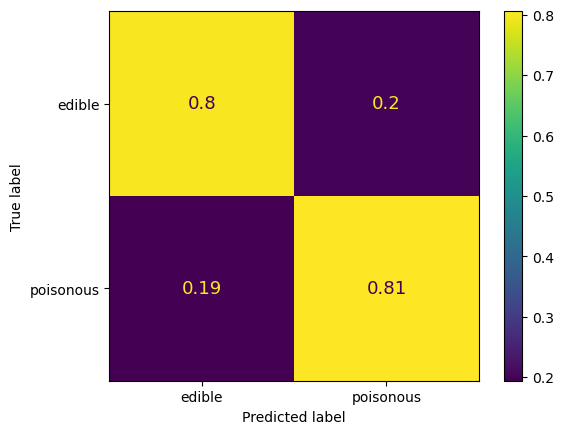

In [15]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(true, predicted, normalize='true', display_labels = ['edible', 'poisonous'], text_kw = {'fontsize': 13})


In [16]:
class_names = ['edible', 'poisonous']
pos_class = 0

tp = 0
fp = 0
fn = 0
#### Insert your code here that finds the TP, FP and FN counts for the 'Hound' positive class in the dataset
for i in range(len(true)):
    gt_i = true[i]
    pred_i = predicted[i]

    if gt_i ==0 and pred_i == 0:
        tp+= 1

    if gt_i == 0 and pred_i != 0:
        fn+= 1
    if gt_i !=0 and pred_i == 0:
        fp+= 1
        
    
############################################################################################################



prec = tp/(tp+fp)
rec = tp/(tp+fn)

print('For the Edible Class')
print(f'Precision: {100.*prec :.1f}%, Recall: {100.*rec :.1f}%')

For the Edible Class
Precision: 77.9%, Recall: 80.0%


In [17]:
all_gt = []
all_pred = []
all_confidence = []

for data in valloader:
        inputs, labels = data
        inputs = inputs.to(device)
        

        outputs = resnet_frozen(inputs)
        
        predicted = torch.argmax(outputs, axis = 1)
        all_pred += predicted.tolist()
        all_gt += labels.tolist()

        softmax = torch.nn.functional.softmax(outputs)
        confidence, predicted = torch.max(softmax, axis = 1)
        all_confidence += confidence.tolist()
         

/tmp/ipykernel_2041/43847230.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  softmax = torch.nn.functional.softmax(outputs)


/tmp/ipykernel_2041/1063397727.py:26: RuntimeWarning: invalid value encountered in scalar divide
  accuracy = correct/total


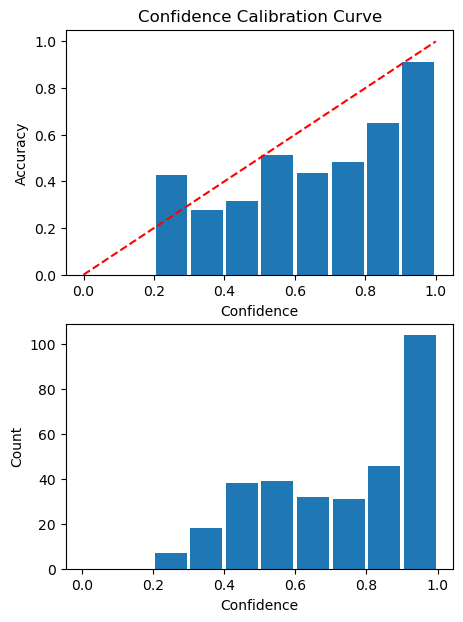

In [18]:
#create a variable that holds the confidence intervals we will check on a confidence calibration curve
conf_ranges = [[0, 10], [10, 20], [20, 30], [30, 40], [40, 50], [50, 60], [60, 70], [70, 80], [80, 90], [90, 100]] 

#convert our previously collected lists into numpy arrays so that we can easily manipulate them
all_pred_conf = np.array(all_confidence)
all_pred_class = np.array(all_pred)
all_gt_class = np.array(all_gt)

actual_accuracy = []
conf_level = []
conf_counts = []
for conf_int in conf_ranges:
    lower = conf_int[0]/100 #convert between 0-1
    upper = conf_int[1]/100 #convert between 0-1

    #create a mask that will collect predictions in the confidence interval -- it must be above the lower thresh AND below the upper thresh
    mask = (all_pred_conf >= lower) & (all_pred_conf < upper)
    
    #collect all predictions and GT data within the range using the mask
    preds = all_pred_class[mask]
    gt = all_gt_class[mask]
    
    #find the accuracy of this bin by checking how many correct/total
    correct = np.sum(preds == gt)
    total = len(preds)
    accuracy = correct/total
    actual_accuracy += [accuracy] #save the accuracy for this bin to plot later
    conf_level += [(upper + lower)/2] #this is the average confidence level for this confidence interval (not necessarily for the predictions in the bin though), we will use this for plotting later

    #how many samples in this bin?
    conf_counts += [len(preds)]


#Create a figure 
fig, ax = plt.subplots(2, 1, figsize = (5, 7))
ax[0].bar(conf_level, actual_accuracy, width = 0.09)
ax[0].plot([0, 1], [0, 1], 'r--') #our well-calibrated line
ax[0].set_xlabel('Confidence')
ax[0].set_ylabel('Accuracy')
ax[0].set_title('Confidence Calibration Curve')

ax[1].bar(conf_level, conf_counts, width = 0.09)
ax[1].set_xlabel('Confidence')
ax[1].set_ylabel('Count')

plt.savefig('Confidence_curve.png')
plt.show()